# Проект по дисциплине Python for Data Analysis

Проект выполнила команда №2 из студентов 1-го курса МНАД ФКН ВШЭ:

• Полина Наволоцкая — выполнила часть с парсингом данных: написала код для сбора данных о стоимости аренды недвижимости в Москве с сайта cian.ru и выгрузила датасет.

• Георгий Невинный и Юлия Демьянова — исследовали «сырой» датасет, обработали пропуски и выбросы в данных.

• Владислав Смирнов — создал новые признаки и провёл разведывательный анализ данных с использованием описательных статистик и графиков.

Проект нацелен на исследование рынка аренды недвижимости в Москве.

In [302]:
import time
import random
import re
import os
from tqdm import tqdm

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Этап 0 Парсинг данных

#### Паплайн парсинга

##### 1. Собираем ссылки на объявления об аренде квартир с https://www.cian.ru/snyat-kvartiru/ и сохраняем в локальный файл

##### 2. Проходимся итеративно парсером по каждой из ссылок и достаем со страницы объявления всю информацию, до которой можем дотянуться

p.s. регулярно автосохраняемся и сохраняем чекпоинты на случай, если что-то упадет

p.p.s. добавляем логирование, чтобы видеть, что все идет (не) по плану


In [ ]:
def make_driver(headless=True):
    options = Options()
    if headless:
        options.add_argument("--headless=new")

    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("window-size=1920,1080")

    driver = webdriver.Chrome(options=options)
    driver.implicitly_wait(5)
    return driver


def scroll_page(driver, max_scrolls=6, pause=1.2):
    """Просто крутим страницу вниз несколько раз"""
    last_height = driver.execute_script("return document.body.scrollHeight")
    for _ in range(max_scrolls):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(pause + random.random())
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height


def get_listing_links(html):
    """Достаём только ссылки на объявления аренды квартир"""
    soup = BeautifulSoup(html, "html.parser")
    links = set()

    for a in soup.find_all("a", href=True):
        href = a["href"]

        # берем только ссылки вида:
        # https://www.cian.ru/rent/flat/.../123456789/
        if href.startswith("https://www.cian.ru/rent/flat") and re.search(r"/\d{6,}/$", href):
            links.add(href)

    return links


def save_links(links, filename):
    df = pd.DataFrame(sorted(list(links)), columns=["url"])
    df.to_csv(filename, index=False, encoding="utf-8")
    print(f"Сохранено {len(df)} ссылок в {filename}")


def get_next_page_url(driver):
    """Пытаемся найти кнопку 'Дальше' и взять из неё ссылку"""
    try:
        next_btn = driver.find_element(By.XPATH, "//a[span[text()='Дальше']]")
        return next_btn.get_attribute("href")
    except NoSuchElementException:
        return None


def collect_cian_links(start_url,
                       min_count=1500,
                       save_every_n_pages=3,
                       save_file="cian_links.csv"):

    driver = make_driver(headless=False)
    driver.get(start_url)
    time.sleep(2)

    all_links = set()
    page_num = 1

    while len(all_links) < min_count:

        scroll_page(driver)
        html = driver.page_source
        new_links = get_listing_links(html)

        print(f"Новых ссылок на странице: {len(new_links)}")
        all_links.update(new_links)
        print(f"Всего найдено ссылок: {len(all_links)}")

        if page_num % save_every_n_pages == 0:
            save_links(all_links, save_file)

        next_url = get_next_page_url(driver)
        if not next_url:
            break

        print(f"Переходим на: {next_url}")
        driver.get(next_url)
        time.sleep(2 + random.random())
        page_num += 1

    # финальное сохранение
    save_links(all_links, save_file)

    driver.quit()
    return list(all_links)


In [ ]:
if __name__ == "__main__":
    links = collect_cian_links(
        start_url="https://www.cian.ru/snyat-kvartiru/",
        min_count=15000,
        save_every_n_pages=3,     # сохраняем каждые 3 страницы
        save_file="cian_links.csv"
    )



=== Страница 1 ===
Новых ссылок на странице: 28
Всего найдено ссылок: 28
Переходим на: https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=2&region=1&type=4

=== Страница 2 ===
Новых ссылок на странице: 28
Всего найдено ссылок: 47
Переходим на: https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=3&region=1&type=4

=== Страница 3 ===
Новых ссылок на странице: 28
Всего найдено ссылок: 75
Сохранено 75 ссылок в cian_links.csv
Переходим на: https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=4&region=1&type=4

=== Страница 4 ===
Новых ссылок на странице: 28
Всего найдено ссылок: 84
Переходим на: https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=5&region=1&type=4

=== Страница 5 ===
Новых ссылок на странице: 28
Всего найдено ссылок: 111
Переходим на: https://www.cian.ru/cat.php?deal_type=rent&engine_version=2&offer_type=flat&p=6&region=1&type=4

=== Страница 6 ===
Новых ссылок на страни

In [ ]:
def make_driver(headless=True):
    """Создает драйвер Chrome"""
    options = Options()
    if headless:
        options.add_argument("--headless=new")

    options.add_argument("--disable-blink-features=AutomationControlled")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-dev-shm-usage")
    options.add_argument("window-size=1920,1080")

    driver = webdriver.Chrome(options=options)
    driver.implicitly_wait(5)
    return driver


def parse_price(price_text):
    """Извлекает цену из текста"""
    if not price_text:
        return None
    numbers = re.findall(r'\d+', price_text.replace('\xa0', '').replace(' ', ''))
    if numbers:
        return int(''.join(numbers))
    return None


def parse_area(area_text):
    """Извлекает площадь из текста"""
    if not area_text:
        return None
    match = re.search(r'(\d+(?:\.\d+)?)', area_text.replace('\xa0', '').replace(' ', ''))
    if match:
        return float(match.group(1))
    return None


def parse_floor(floor_text):
    """Извлекает этаж и общее количество этажей"""
    if not floor_text:
        return None, None
    match = re.search(r'(\d+)\s*из\s*(\d+)', floor_text)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None


def parse_metro_time(metro_text):
    """Извлекает время до метро в минутах"""
    if not metro_text:
        return None
    match = re.search(r'(\d+)\s*мин', metro_text)
    if match:
        return int(match.group(1))
    return None


def parse_cian_page(url, driver):
    """Парсит страницу объявления с Циана через Selenium"""
    
    try:
        driver.get(url)
        
        # Ждем загрузки страницы
        time.sleep(3)
        
        # Получаем HTML
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        # Инициализируем словарь с данными
        data = {}
        
        # ЦЕНА
        price_container = soup.find(attrs={'data-testid': 'price-amount'})

        if price_container:
        # Берём либо внутренний span, либо сам контейнер
            price_span = price_container.find('span') or price_container
            price_text = price_span.get_text(strip=True)
            data['price_monthly'] = parse_price(price_text)
        else:
            data['price_monthly'] = None
        
        # КОЛИЧЕСТВО КОМНАТ
        title = soup.find('h1', class_=re.compile('title'))
        if title:
            title_text = title.get_text()
            if '1-комн' in title_text:
                data['rooms'] = 1
            elif '2-комн' in title_text:
                data['rooms'] = 2
            elif '3-комн' in title_text:
                data['rooms'] = 3
            elif '4-комн' in title_text:
                data['rooms'] = 4
            elif 'Студия' in title_text or 'студия' in title_text:
                data['rooms'] = 0
            else:
                data['rooms'] = None
        else:
            data['rooms'] = None
        
        # ПЛОЩАДИ ИЗ ObjectFactoids
        factoid_items = soup.find_all('div', {'data-name': 'ObjectFactoidsItem'})
        
        for item in factoid_items:
            label_elem = item.find('span', class_=re.compile('gray'))
            value_elem = item.find('span', class_=re.compile('text-primary.*bold'))
            
            if label_elem and value_elem:
                label = label_elem.get_text().strip()
                value = value_elem.get_text().strip()
                
                if 'Общая площадь' in label:
                    data['total_area'] = parse_area(value)
                elif 'Жилая площадь' in label:
                    data['living_area'] = parse_area(value)
                elif 'Площадь кухни' in label:
                    data['kitchen_area'] = parse_area(value)
                elif 'Этаж' in label:
                    floor, total_floors = parse_floor(value)
                    data['floor'] = floor
                    data['total_floors'] = total_floors
                elif 'Год постройки' in label:
                    try:
                        data['build_year'] = int(value.strip())
                    except:
                        data['build_year'] = None
        
        # ДОПОЛНИТЕЛЬНЫЕ ДАННЫЕ ИЗ OfferSummaryInfoItem
        summary_items = soup.find_all('div', {'data-name': 'OfferSummaryInfoItem'})
        
        for item in summary_items:
            paragraphs = item.find_all('p')
            if len(paragraphs) >= 2:
                label = paragraphs[0].get_text().strip()
                value = paragraphs[1].get_text().strip()
                
                if 'Общая площадь' in label and not data.get('total_area'):
                    data['total_area'] = parse_area(value)
                elif 'Жилая площадь' in label and not data.get('living_area'):
                    data['living_area'] = parse_area(value)
                elif 'Площадь кухни' in label and not data.get('kitchen_area'):
                    data['kitchen_area'] = parse_area(value)
                elif 'Санузел' in label:
                    data['bathroom_type'] = value
                elif 'Балкон' in label or 'лоджия' in label:
                    data['balcony'] = value
                elif 'Ремонт' in label:
                    data['renovation'] = value
                elif 'Год постройки' in label and not data.get('build_year'):
                    try:
                        data['build_year'] = int(value.strip())
                    except:
                        data['build_year'] = None
                elif 'Строительная серия' in label:
                    data['building_series'] = value
                elif 'Тип дома' in label:
                    data['building_type'] = value
                elif 'Тип перекрытий' in label:
                    data['ceiling_type'] = value
                elif 'Подъезды' in label:
                    try:
                        data['entrances'] = int(value.strip())
                    except:
                        data['entrances'] = None
                elif 'Отопление' in label:
                    data['heating'] = value
                elif 'Аварийность' in label:
                    data['is_emergency'] = 1 if 'Да' in value else 0
        
        # АДРЕС
        address_container = soup.find('div', {'data-name': 'AddressContainer'})
        if address_container:
            address_items = address_container.find_all('a', {'data-name': 'AddressItem'})
            if len(address_items) >= 2:
                data['district'] = address_items[1].get_text().strip()
            if len(address_items) >= 3:
                data['subdistrict'] = address_items[2].get_text().strip()
            else:
                data['subdistrict'] = None
        else:
            data['district'] = None
            data['subdistrict'] = None
        
        # МЕТРО
        metro_items = soup.find_all('li', {'data-name': 'UndergroundItem'})
        if metro_items:
            first_metro = metro_items[0]
            metro_link = first_metro.find('a', class_=re.compile('underground_link'))
            if metro_link:
                data['metro_name'] = metro_link.get_text().strip()
            else:
                data['metro_name'] = None
            
            metro_time_span = first_metro.find('span', class_=re.compile('underground_time'))
            if metro_time_span:
                data['metro_time_minutes'] = parse_metro_time(metro_time_span.get_text())
            else:
                data['metro_time_minutes'] = None
            
           
        else:
            data['metro_name'] = None
            data['metro_time_minutes'] = None
        
        # ЖК
        parent_elem = soup.find('div', {'data-name': 'ParentNew'})
        if parent_elem:
            zhk_link = parent_elem.find('a')
            if zhk_link:
                data['residential_complex'] = zhk_link.get_text().strip()
            else:
                data['residential_complex'] = None
        else:
            data['residential_complex'] = None
        
        # УСЛОВИЯ АРЕНДЫ
        fact_items = soup.find_all('div', {'data-name': 'OfferFactItem'})
        
        for item in fact_items:
            spans = item.find_all('span')
            if len(spans) >= 2:
                label = spans[0].get_text().strip()
                value = spans[-1].get_text().strip()
                
                if 'Оплата ЖКХ' in label:
                    data['utilities_included'] = 1 if 'включена' in value else 0
                elif 'Залог' in label:
                    data['deposit'] = parse_price(value)
                elif 'Комиссии' in label:
                    data['has_commission'] = 0 if 'нет' in value.lower() else 1
                elif 'Предоплата' in label:
                    data['prepayment_months'] = value
                elif 'Срок аренды' in label:
                    data['min_lease_term'] = value
                elif 'Условия проживания' in label:
                    data['living_conditions'] = value
        
        # МЕБЕЛЬ И ТЕХНИКА
        furniture_items = soup.find_all('div', {'data-name': 'FeaturesItem'})
        
        data['has_fridge'] = 0
        data['has_dishwasher'] = 0
        data['has_washing_machine'] = 0
        data['has_conditioner'] = 0
        data['has_tv'] = 0
        data['has_internet'] = 0
        data['has_bath'] = 0
        data['has_shower'] = 0
        data['has_kitchen_furniture'] = 0
        data['has_room_furniture'] = 0
        
        for item in furniture_items:
            item_span = item.find('span')
            if item_span:
                text = item_span.get_text().lower()
                
                if 'холодильник' in text:
                    data['has_fridge'] = 1
                if 'посудомоечная' in text:
                    data['has_dishwasher'] = 1
                if 'стиральная' in text:
                    data['has_washing_machine'] = 1
                if 'кондиционер' in text:
                    data['has_conditioner'] = 1
                if 'телевизор' in text:
                    data['has_tv'] = 1
                if 'интернет' in text:
                    data['has_internet'] = 1
                if 'ванна' in text and 'мастер' not in text:
                    data['has_bath'] = 1
                if 'душевая' in text:
                    data['has_shower'] = 1
                if 'мебель на кухне' in text:
                    data['has_kitchen_furniture'] = 1
                if 'мебель в комнатах' in text:
                    data['has_room_furniture'] = 1
        
        tech_count = sum([data['has_fridge'], data['has_dishwasher'], data['has_washing_machine'], 
                         data['has_conditioner'], data['has_tv'], data['has_internet']])
        
        # ОПИСАНИЕ
        description_elem = soup.find('div', {'data-name': 'Description'})
        if description_elem:
            description_span = description_elem.find('span', class_=re.compile('whiteSpace__pre-wrap'))
            if description_span:
                data['description'] = description_span.get_text().strip()
            else:
                data['description'] = None
        else:
            data['description'] = None
        
        # ТИП АГЕНТА
        author_title = soup.find('div', {'data-name': 'SubscriptionAuthorTitle'})
        if author_title:
            author_type_text = author_title.get_text().strip()
            if 'Агентство' in author_type_text:
                data['agent_type'] = 'agency'
            elif 'Собственник' in author_type_text:
                data['agent_type'] = 'owner'
            else:
                data['agent_type'] = 'other'
        else:
            data['agent_type'] = None
        
        return data
    
    except Exception as e:
        print(f"Ошибка при парсинге {url}: {e}")
        import traceback
        traceback.print_exc()
        return None


def parse_dataset(input_file, output_file, checkpoint_file='parsing_checkpoint.csv', save_every=5, headless=False):
    """Парсит датасет с ссылками и сохраняет результат"""
    
    # Читаем датасет
    df = pd.read_csv(input_file)
    
    
    # Список для хранения распарсенных данных
    parsed_data = []
    
    # Проверяем, есть ли файл чекпоинта (восстановление после прерывания)
    start_idx = 0
    if os.path.exists(checkpoint_file):
        checkpoint_df = pd.read_csv(checkpoint_file)
        parsed_data = checkpoint_df.to_dict('records')
        start_idx = len(parsed_data)
    
    driver = make_driver(headless=False)
    
    try:
        # Парсим каждую ссылку начиная с start_idx
        for idx in tqdm(range(start_idx, len(df)), desc="Парсинг объявлений", initial=start_idx, total=len(df)):
            url = df.iloc[idx]['url']
            data = parse_cian_page(url, driver)
            
            if data:
                data['url'] = url
                parsed_data.append(data)

            else:
                parsed_data.append({'url': url})
            
            # Автосохранение каждые N объявлений
            if (idx + 1) % save_every == 0:
                temp_df = pd.DataFrame(parsed_data)
                temp_df.to_csv(checkpoint_file, index=False, encoding='utf-8-sig')
            
            # Задержка между запросами
            time.sleep(2)
        
        
    except Exception as e:
        print(f"\n\Ошибка: {e}")
        temp_df = pd.DataFrame(parsed_data)
        temp_df.to_csv(checkpoint_file, index=False, encoding='utf-8-sig')
        
    finally:
        # Закрываем драйвер
        print("\nЗакрываем браузер...")
        driver.quit()
    
    result_df = pd.DataFrame(parsed_data)
    
    # Сохраняем финальный результат
    result_df.to_csv(output_file, index=False, encoding='utf-8-sig')
    
    # Удаляем чекпоинт после завершения
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)
    
    return result_df





In [2]:
input_file = "cian_links.csv"  
output_file = "cian_parsed_data_full.csv"  # Финальный результат

# Запуск парсинга всего датасета с автосохранением каждые 5 объявлений
parse_dataset(
    input_file=input_file,
    output_file=output_file,
    checkpoint_file='parsing_checkpoint.csv',
    save_every=5,  # Сохранять каждые 5 объявлений
    headless=False
)

Парсинг объявлений: 100%|██████████| 1344/1344 [4:59:07<00:00, 13.35s/it]  



Закрываем браузер...


,price_monthly,rooms,total_area,living_area,kitchen_area,floor,total_floors,build_year,bathroom_type,balcony,...,has_conditioner,has_tv,has_internet,has_bath,has_shower,has_kitchen_furniture,has_room_furniture,description,agent_type,url
0,1100000.0,2.0,122.0,100.0,10.0,5.0,7.0,2008.0,2 совмещенных,1 балкон,...,1,1,1,1,1,1,1,"АГЕНТУ МАКСИМАЛЬНЫЙ БОНУС! Элитный ЖК ""Баркли ...",agency,https://www.cian.ru/rent/flat/154971500/
1,47000.0,1.0,35.0,17.0,5.0,1.0,5.0,1967.0,NaN,NaN,...,0,0,0,1,0,1,1,"Объявление снято с публикации, поищите ещё что...",None,https://www.cian.ru/rent/flat/157864857/
2,110000.0,2.0,70.0,38.0,10.0,23.0,25.0,2018.0,2 раздельных,NaN,...,1,1,1,1,0,1,1,"Цена актуальная, комиссии нет,метро 5 минут,жи...",None,https://www.cian.ru/rent/flat/182526793/
3,550000.0,3.0,150.0,NaN,NaN,25.0,53.0,2011.0,"2 совмещенных, 1 раздельный",NaN,...,1,1,1,1,1,1,1,Видовая современная трехкомнатная квартира в д...,agency,https://www.cian.ru/rent/flat/195164445/
4,130000.0,2.0,53.0,31.0,6.0,5.0,9.0,1973.0,1 раздельный,"1 лоджия, 1 балкон",...,1,1,1,1,0,1,1,Квартира от собственника без посредников в кир...,None,https://www.cian.ru/rent/flat/203500577/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1339,54000.0,0.0,21.0,13.0,3.0,11.0,18.0,2022.0,1 совмещенный,NaN,...,0,0,0,0,0,1,1,ОТ СОБСТВЕННИКА сдаётся уютная студия на длите...,None,https://www.cian.ru/rent/flat/324895746/
1340,65000.0,1.0,32.0,20.0,6.0,5.0,5.0,1965.0,NaN,NaN,...,0,1,1,0,1,1,1,Сдается 1-к квартира на Кутузовском проспекте!...,None,https://www.cian.ru/rent/flat/324895837/
1341,350000.0,2.0,124.0,48.0,20.0,4.0,5.0,2002.0,2 совмещенных,NaN,...,1,1,1,1,1,1,1,Лот 106379. Нина Дуванская.\n\nСтильная 2-комн...,other,https://www.cian.ru/rent/flat/324897881/
1342,90000.0,2.0,43.0,22.0,10.0,7.0,30.0,2024.0,1 совмещенный,NaN,...,1,1,1,1,0,1,1,"Уважаемые арендаторы, мы ценим ваше время потр...",None,https://www.cian.ru/rent/flat/324901537/


## Этап 1 Предварительная обработка

### **Описание собранных признаков**

#### Цена и условия аренды

* **price_monthly** — стоимость аренды в месяц
* **utilities_included** — входит ли оплата ЖКХ
* **deposit** — размер залога
* **has_commission** — есть ли комиссия
* **prepayment_months** — предоплата (кол-во месяцев)
* **min_lease_term** — минимальный срок аренды
* **living_conditions** — условия проживания (можно/нельзя с детьми, животными и т.д.)

#### Характеристики квартиры

* **rooms** — число комнат (0 = студия)
* **total_area** — общая площадь
* **living_area** — жилая площадь
* **kitchen_area** — площадь кухни
* **floor** — этаж
* **total_floors** — всего этажей в доме
* **bathroom_type** — тип и количество санузлов
* **balcony** — наличие/тип балкона или лоджии
* **renovation** — тип ремонта

#### Параметры дома

* **build_year** — год постройки
* **building_series** — серия дома
* **building_type** — тип здания (панельный, монолит и т.д.)
* **ceiling_type** — тип перекрытий
* **entrances** — количество подъездов
* **heating** — тип отопления
* **is_emergency** — аварийность здания

#### Локация

* **district** — административный округ
* **subdistrict** — район внутри округа
* **metro_name** — ближайшее метро
* **metro_time_minutes** — время до метро (минут пешком/транспортом)
* **residential_complex** — название ЖК (если есть)

#### Мебель и техника (есть или нет)

* **has_fridge** — холодильник
* **has_dishwasher** — посудомойка
* **has_washing_machine** — стиральная машина
* **has_conditioner** — кондиционер
* **has_tv** — телевизор
* **has_internet** — интернет/Wi-Fi
* **has_bath** — ванна
* **has_shower** — душевая
* **has_kitchen_furniture** — кухонная мебель
* **has_room_furniture** — мебель в комнатах

#### Тип владельца

* **agent_type** — кто размещает: агентство / собственник / другое

#### Описание

* **description** — текстовое описание объявления
* **url** — ссылка на объявление


### Чтение и краткий обзор датасета

In [147]:
df = pd.read_csv('cian_parsed_data_full.csv', encoding='utf-8')

In [148]:
df.head(3)

,price_monthly,rooms,total_area,living_area,kitchen_area,floor,total_floors,build_year,bathroom_type,balcony,...,has_conditioner,has_tv,has_internet,has_bath,has_shower,has_kitchen_furniture,has_room_furniture,description,agent_type,url
0,1100000.0,2.0,122.0,100.0,10.0,5.0,7.0,2008.0,2 совмещенных,1 балкон,...,1,1,1,1,1,1,1,"АГЕНТУ МАКСИМАЛЬНЫЙ БОНУС! Элитный ЖК ""Баркли ...",agency,https://www.cian.ru/rent/flat/154971500/
1,47000.0,1.0,35.0,17.0,5.0,1.0,5.0,1967.0,NaN,NaN,...,0,0,0,1,0,1,1,"Объявление снято с публикации, поищите ещё что...",NaN,https://www.cian.ru/rent/flat/157864857/
2,110000.0,2.0,70.0,38.0,10.0,23.0,25.0,2018.0,2 раздельных,NaN,...,1,1,1,1,0,1,1,"Цена актуальная, комиссии нет,метро 5 минут,жи...",NaN,https://www.cian.ru/rent/flat/182526793/


In [149]:
df.head(1).T

,0
price_monthly,1100000.0
rooms,2.0
total_area,122.0
living_area,100.0
kitchen_area,10.0
floor,5.0
total_floors,7.0
build_year,2008.0
bathroom_type,2 совмещенных
balcony,1 балкон


In [150]:
df.shape

(1344, 41)

In [151]:
df.duplicated().sum()

0

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_monthly          1342 non-null   float64
 1   rooms                  1270 non-null   float64
 2   total_area             1342 non-null   float64
 3   living_area            924 non-null    float64
 4   kitchen_area           1039 non-null   float64
 5   floor                  1342 non-null   float64
 6   total_floors           1342 non-null   float64
 7   build_year             1223 non-null   float64
 8   bathroom_type          1270 non-null   object 
 9   balcony                527 non-null    object 
 10  renovation             1314 non-null   object 
 11  building_series        723 non-null    object 
 12  building_type          861 non-null    object 
 13  ceiling_type           1167 non-null   object 
 14  entrances              810 non-null    float64
 15  heat

Просмотр значений каждой колонки в датасете

In [154]:
for col in df.columns:
    print(f'Признак {col} содержит {df[col].nunique()} уникальных значений.\nУникальные значения следующие: {df[col].unique()}\n\n')

Признак price_monthly содержит 259 уникальных значений.
Уникальные значения следующие: [1100000.   47000.  110000.  550000.  130000.   95000.   55000.  100000.
  125000.  150000.   80000.  165000.   65000.  137417.  135000.   84900.
   56000.   90000.  107500.   85000.  175000.   45000.  250000.  190000.
   75000.   96000.   60000.  600000.  120000.   99750.   68000.  255000.
   81600.  139000. 2100000.  220000.  180000.  300000.  230000.  320000.
  160000.  178000.  279000.  146660.  400000.  187000.  279999.  200000.
   99500.  229000.  109000. 1300000.   79500.   44999.  159000.   70000.
  350000.  370000.   86990.  399000.   87000. 1152126.  377777.  290000.
  115000.  500000.  105000. 1000000.  145000. 3000000.   53000.   50000.
   79990.   54990.   89000.  790000.  360000.  380000.   46990.  140000.
  390000.  330000.  750000.  270000.  285000.  260000.  450000.  210000.
   67000.  680000.  430000.  650000.   97000. 1200000.  280000.  850000.
  310000.  205682.   79000.  525000. 

### Проверка и чистка/замена пропусков

In [156]:
absences = round(df.isna().sum()/len(df)*100, 2).to_frame('percentage_absences').merge(df.isna().sum().to_frame('number_absences'), left_index=True, right_index=True)

absences.sort_values(by='percentage_absences', ascending=False)

,percentage_absences,number_absences
balcony,60.79,817
agent_type,56.99,766
building_series,46.21,621
has_commission,40.48,544
entrances,39.73,534
residential_complex,38.39,516
building_type,35.94,483
living_area,31.25,420
living_conditions,30.88,415
kitchen_area,22.69,305


#### Признаки с очень большим числом пропусков (> 50%)

Отсутствие информации о балконе не означает его отсутствие — чаще всего это просто не указано в объявлении. Признак может быть полезен в анализе, поэтому удалять его нецелесообразно.

In [159]:
df['balcony_clean'] = df['balcony'].fillna('unknown')

Тип арендодателя важен для анализа цены (собственник vs агент), но часто не указывается.

In [161]:
df['agent_type_clean'] = df['agent_type'].fillna('unknown')

#### Признаки с большим числом пропусков (35–50%)

Серия дома не всегда известна или указывается, но может быть важна для анализа характеристик жилья.

In [164]:
df['building_series_clean'] = df['building_series'].fillna('unknown')

In [165]:
df['residential_complex_clean'] = df['residential_complex'].fillna('unknown')

In [166]:
df['building_type_clean'] = df['building_type'].fillna('unknown')

Это бинарный признак. В случае отсутствия информации логично использовать наиболее частое значение.

In [168]:
df['has_commission_clean'] = df['has_commission'].fillna(df['has_commission'].median())

Числовой признак, выбросы возможны, медиана устойчивее среднего.

In [170]:
df['entrances_clean'] = df['entrances'].fillna(df['entrances'].median())

#### Признаки с умеренным числом пропусков (20–35%)

Площади — важные признаки, медиана сохраняет распределение и не искажается выбросами.

In [173]:
df['living_area_clean'] = df['living_area'].fillna(df['living_area'].median())
df['kitchen_area_clean'] = df['kitchen_area'].fillna(df['kitchen_area'].median())

Если мы заполним все пропуски модой, мы искусственно увеличим долю квартир с балконом;

In [175]:
df['living_conditions_clean'] = df['living_conditions'].fillna('unknown')

#### Признаки с небольшим числом пропусков (< 15%)

Признак build_year является количественным и отражает объективную характеристику здания. Пропуски в данном признаке не означают отсутствия года постройки, а связаны с отсутствием информации в объявлении. В связи с этим пропуски были заполнены медианным значением, что позволяет сохранить числовую природу признака и избежать искажения распределения.

In [178]:
df['build_year_clean'] = df['build_year'].fillna(df['build_year'].median())

Если залог не указан, часто это означает его отсутствие.

In [180]:
df['deposit_clean'] = df['deposit'].fillna(0)

Заполняем оставшиеся незначительные пропуски по тому же принципу: пропуски в категориальных признаказ заполняются 'unknown', пропуски в количественных признаках - медианой

In [182]:
df['is_emergency_clean'] = df['is_emergency'].fillna(df['is_emergency'].median())
df['heating_clean'] = df['heating'].fillna('unknown')
df['ceiling_type_clean'] = df['ceiling_type'].fillna('unknown')
df['bathroom_type_clean'] = df['bathroom_type'].fillna('unknown')
df['rooms_clean'] = df['rooms'].fillna(df['rooms'].median())
df['prepayment_months_clean'] = df['prepayment_months'].fillna('unknown')
df['renovation_clean'] = df['renovation'].fillna('unknown')
df['metro_time_minutes_clean'] = df['metro_time_minutes'].fillna(df['metro_time_minutes'].median())

#### Итог обработки пропусков

Мы обработали категориальные признаки, создав новые колонки без пропусков с постфиксом _clean. Мы обработали их заполнив значением unknown, чтобы не сместить распределение искуственным увеличением доли, например, самого часто встречающегося значения.
Также мы обработали количественные признаки, заменив пропуски медианным значением, чтобы избежать смещения распределения, также создав новые колонки с постфиксом _clean.
Один количественный признак (deposit_clean) мы обработали, заменив пропуски на 0, предположив, что отсутствие указанного депозита означает его нулевое значение.
Ни одна строка с пустым значением на данный момент не была удалена, так как при удалении строк по принципу пропусков в значениях могло бы привести к потере до 60% датасета. Столбцы также не удалялись для сохранения важных фичей для последующей аналитики.

Создаем новый датасет с заполненными значениями

In [186]:
clean = df.drop(columns=['balcony','agent_type','building_series','has_commission','entrances','living_area',
                         'kitchen_area','living_conditions','build_year','deposit','residential_complex','building_type','ceiling_type',
                        'heating', 'is_emergency', 'bathroom_type', 'rooms', 'prepayment_months', 'renovation', 'metro_time_minutes'])

Посмотрим на оставшиеся пропуски

In [188]:
missing = clean.isna().mean().sort_values(ascending=False)
(missing * 100).round(2)

metro_name                   0.22
price_monthly                0.15
floor                        0.15
total_floors                 0.15
district                     0.15
subdistrict                  0.15
utilities_included           0.15
min_lease_term               0.15
total_area                   0.15
description                  0.15
deposit_clean                0.00
entrances_clean              0.00
living_area_clean            0.00
kitchen_area_clean           0.00
living_conditions_clean      0.00
build_year_clean             0.00
bathroom_type_clean          0.00
is_emergency_clean           0.00
heating_clean                0.00
ceiling_type_clean           0.00
building_type_clean          0.00
rooms_clean                  0.00
prepayment_months_clean      0.00
renovation_clean             0.00
has_commission_clean         0.00
url                          0.00
residential_complex_clean    0.00
building_series_clean        0.00
agent_type_clean             0.00
balcony_clean 

Здесь пропусков очень мало (~0.15%), можем удалить эти строки


In [190]:
clean = clean.dropna(subset=[
    'metro_name', 'price_monthly', 'total_area', 'floor',
    'total_floors', 'district', 'subdistrict'
])

In [191]:
missing = clean.isna().mean().sort_values(ascending=False)
(missing * 100).round(2)

price_monthly                0.0
balcony_clean                0.0
building_series_clean        0.0
residential_complex_clean    0.0
building_type_clean          0.0
has_commission_clean         0.0
entrances_clean              0.0
living_area_clean            0.0
kitchen_area_clean           0.0
living_conditions_clean      0.0
build_year_clean             0.0
deposit_clean                0.0
is_emergency_clean           0.0
heating_clean                0.0
ceiling_type_clean           0.0
bathroom_type_clean          0.0
rooms_clean                  0.0
prepayment_months_clean      0.0
renovation_clean             0.0
agent_type_clean             0.0
url                          0.0
total_area                   0.0
description                  0.0
floor                        0.0
total_floors                 0.0
district                     0.0
subdistrict                  0.0
metro_name                   0.0
utilities_included           0.0
min_lease_term               0.0
has_fridge

In [192]:
clean.shape

(1341, 41)

### Обработка выбросов

Проверим, где 99 перцентиль сильно отличается от медианы, есть ли скачки по признакам цены, площади, расстояния до метро

In [195]:
clean[['price_monthly', 'total_area', 'metro_time_minutes_clean']].describe(
    percentiles=[0.01, 0.05, 0.95, 0.99]
)

,price_monthly,total_area,metro_time_minutes_clean
count,1.341000e+03,1341.000000,1341.000000
mean,2.503422e+05,81.371365,10.011186
std,2.926609e+05,61.858342,5.249508
min,2.999000e+04,14.000000,1.000000
1%,4.288000e+04,19.000000,2.000000
5%,5.250000e+04,22.000000,3.000000
50%,1.500000e+05,62.000000,9.000000
95%,7.900000e+05,196.000000,20.000000
99%,1.460000e+06,303.400000,24.000000
max,3.500000e+06,633.000000,25.000000


Рассмотрим арендную плату

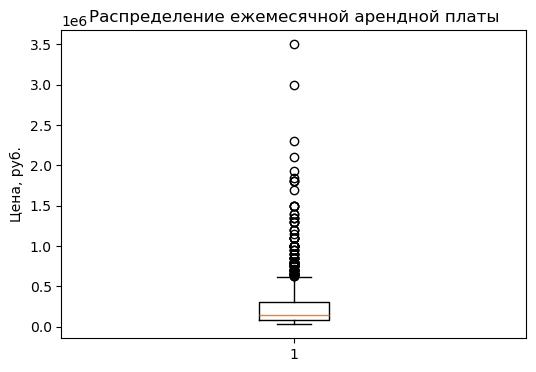

In [197]:
plt.figure(figsize=(6, 4))
plt.boxplot(clean['price_monthly'])
plt.title('Распределение ежемесячной арендной платы')
plt.ylabel('Цена, руб.')
plt.show()

Присутствуют значения, выходящие за пределы межквартильного размаха; распределение асимметрично (что типично для цен на недвижимость).
Это ожидаемое поведение для рынка аренды, а не ошибка данных.

Проверим верхние значения

In [200]:
q1 = clean['price_monthly'].quantile(0.25)
q3 = clean['price_monthly'].quantile(0.75)
iqr = q3 - q1

In [201]:
clean[['price_monthly', 'metro_name', 'total_area']].sort_values(by='price_monthly', ascending=False).head(10)

,price_monthly,metro_name,total_area
364,3500000.0,Спортивная,305.0
126,3000000.0,Парк Культуры,633.0
351,2300000.0,Парк Культуры,430.0
51,2100000.0,Кропоткинская,430.0
426,1930000.0,Крылатское,315.0
332,1843402.0,Народное Ополчение,600.0
384,1800000.0,Тверская,250.0
857,1800000.0,Маяковская,160.0
382,1800000.0,Арбатская,250.0
614,1699108.0,Кропоткинская,286.0


Анализ распределения признака price_monthly показал наличие экстремальных значений, однако они соответствуют реальным рыночным предложениям премиального сегмента и не являются ошибками измерения. В связи с этим данные наблюдения были сохранены в выборке.

Посмотрим зависимость общей площади квартиры количества комнат.

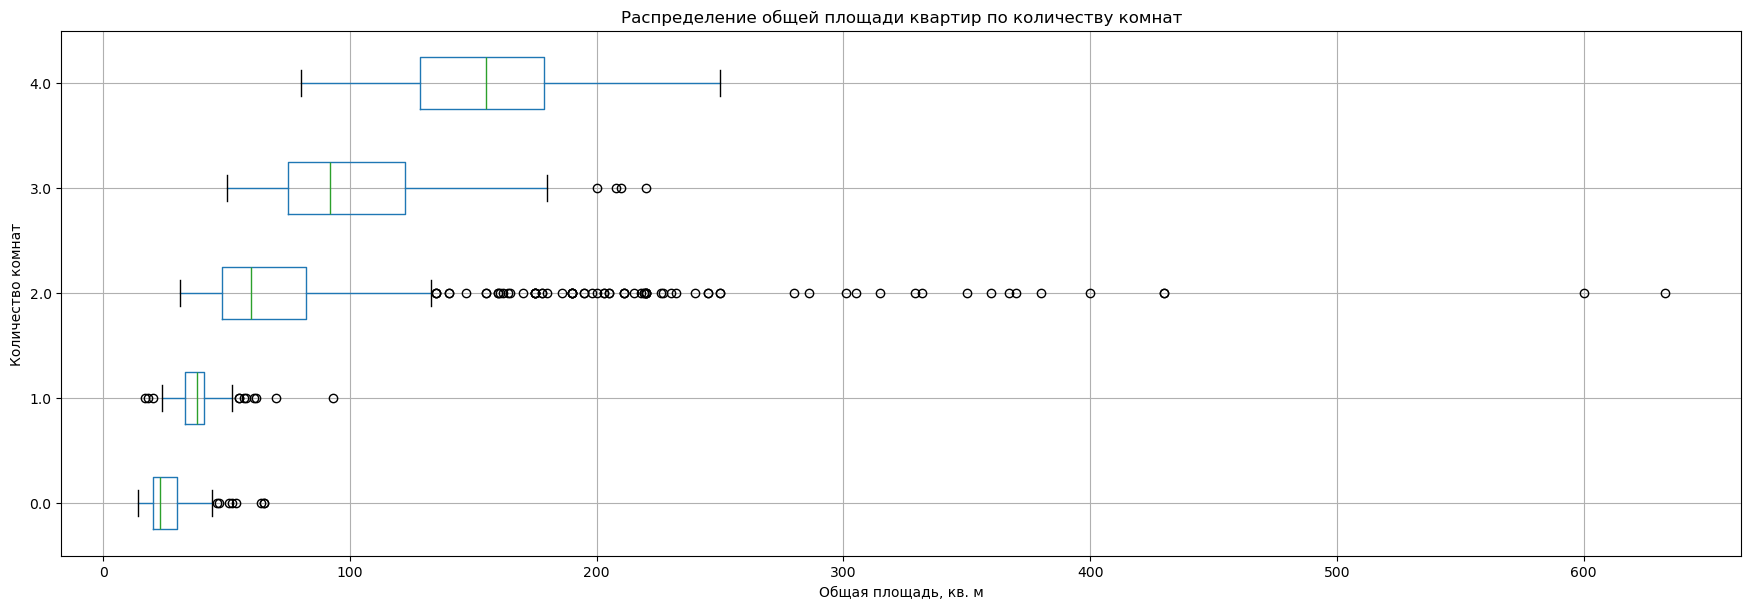

In [204]:
clean.boxplot(column="total_area", by="rooms_clean", figsize=(21, 7), vert=False)
plt.ylabel("Количество комнат")
plt.xlabel("Общая площадь, кв. м")
plt.suptitle("")
plt.title("Распределение общей площади квартир по количеству комнат")
plt.show()

Из данного графика можно сделать вывод, что чем больше комнат, тем больше площадь квартир.
В сегменте двухкомнатных квартир наблюдается большое количество выбросов.
Это может свидельствовать как о некоректно заполенных данных пользователями, так и о наличии нестандартных планировок

In [209]:
quant3 = clean[clean['rooms_clean'] == 2]['total_area'].quantile(0.75)
n_emissions_2rooms = clean[clean['total_area'] > quant3 * 1.5].shape[0]
print(f'Количество выбросов в сегменте двухкомнатных квартир: {n_emissions_2rooms}')

Количество выбросов в сегменте двухкомнатных квартир: 266


В любом случсае, дабы избежать искажений в результатах, удалим из выборки выбросы превышающие полтора межквартильных размаха (+- 1.5*IQR)

In [245]:
df_clean = pd.DataFrame()
for n_room in sorted(clean['rooms_clean'].unique()):
	part = clean[clean['rooms_clean'] == n_room]
	q1 = part['total_area'].quantile(0.25)
	q3 = part['total_area'].quantile(0.75)
	iqr = q3 - q1
	part_clean = part[
		(part['total_area'] >= q1 - 1.5 * iqr) & (part['total_area'] <= q3 + 1.5 * iqr)
		]
	df_clean = pd.concat([df_clean, part_clean], ignore_index=True)

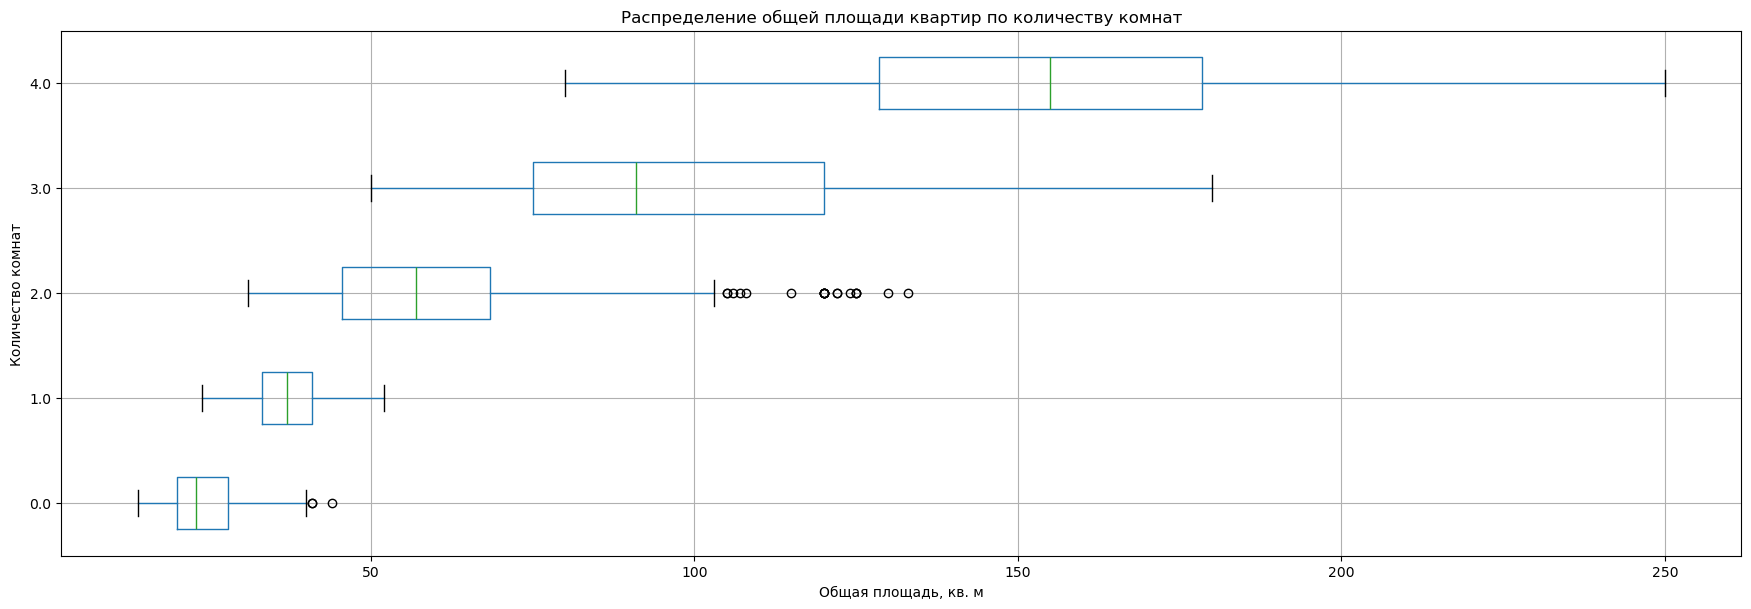

In [249]:
df_clean.boxplot(column="total_area", by="rooms_clean", figsize=(21, 7), vert=False)
plt.ylabel("Количество комнат")
plt.xlabel("Общая площадь, кв. м")
plt.suptitle("")
plt.title("Распределение общей площади квартир по количеству комнат")
plt.show()

Мы снова наблюдаем выбросы... Это случилось из-за того, после удаления части данных границы квантилей сдвинулись. Проделываем процедуру удаления повторно.

In [251]:
df_clean2 = pd.DataFrame()
for n_room in sorted(df_clean['rooms_clean'].unique()):
	part = df_clean[df_clean['rooms_clean'] == n_room]
	q1 = part['total_area'].quantile(0.25)
	q3 = part['total_area'].quantile(0.75)
	iqr = q3 - q1
	part_clean = part[
		(part['total_area'] >= q1 - 1.5 * iqr) & (part['total_area'] <= q3 + 1.5 * iqr)
		]
	df_clean2 = pd.concat([df_clean2, part_clean], ignore_index=True)

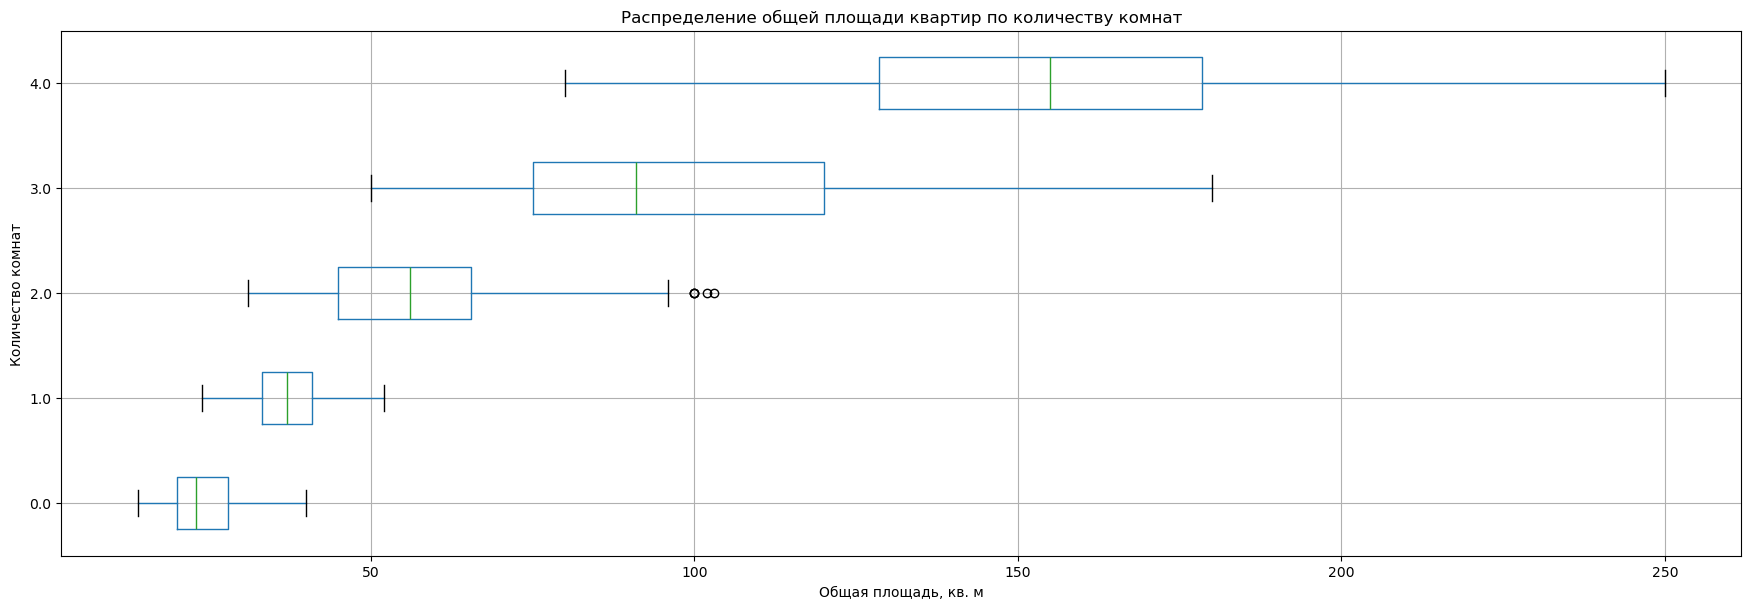

In [253]:
df_clean2.boxplot(column="total_area", by="rooms_clean", figsize=(21, 7), vert=False)
plt.ylabel("Количество комнат")
plt.xlabel("Общая площадь, кв. м")
plt.suptitle("")
plt.title("Распределение общей площади квартир по количеству комнат")
plt.show()

Выбросы остались, но они не значительны, удалять их не будем.

## Этап 2 Предобработка данных и создание новых признаков

In [255]:
#перезапишем очищенный датасет в переменную с более удобным названием
df = df_clean2
#переименуем колонки, приведем к исходному виду
df.columns = df.columns.str.replace('_clean$', '', regex=True)

In [257]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_monthly          1221 non-null   float64
 1   total_area             1221 non-null   float64
 2   floor                  1221 non-null   float64
 3   total_floors           1221 non-null   float64
 4   district               1221 non-null   object 
 5   subdistrict            1221 non-null   object 
 6   metro_name             1221 non-null   object 
 7   utilities_included     1221 non-null   float64
 8   min_lease_term         1221 non-null   object 
 9   has_fridge             1221 non-null   int64  
 10  has_dishwasher         1221 non-null   int64  
 11  has_washing_machine    1221 non-null   int64  
 12  has_conditioner        1221 non-null   int64  
 13  has_tv                 1221 non-null   int64  
 14  has_internet           1221 non-null   int64  
 15  has_

### Создадим новые признаки
- Условия проживания разделим на 2 булевых признака: можно или нет с животными, можно или нет с детьми.
- Тип санузела содержит кол-во санузлов, как совмещенных, так и раздельных, поэтому, чтобы не потерять никакую информацию сделаем из него 5 признаков: количество раздельных санузлов, флаг, есть ли раздельный санузел, количество совмещенных санузлов, флаг, есть ли совмещенный санузел, и общее количество санузлов в квартире
- Признак предоплаты содержит строку вида «N месяцев», извлечём из него числовое значение и приведём к целому типу.
- Признак балкона может включать в себя как балконы, так и лоджии, а также их комбинации. Чтобы сохранить структуру и не потерять информацию, разобьём его на 5 признаков: количество балконов, количество лоджий, флаг наличия хотя бы одного балкона, флаг наличия хотя бы одной лоджии и общее суммарное количество балконов и лоджий в квартире
- Минимальный срок аренды имеет только два осмысленных значения («от года» и «несколько месяцев»), поэтому создадим один бинарный признак, отражающий долгосрочность аренды (размещение «от года»)
- Тип агента содержит категории «agency» и «other», поэтому создадим один признак, показывающий, размещено ли объявление агентством.

In [281]:
def split_conditions(x):
    # Если данных нет, оставляем пропуски
    if pd.isna(x):
        return pd.Series([np.nan, np.nan])
    s = str(x).lower()
    pets = 'животными' in s
    kids = 'детьми' in s

    return pd.Series([kids, pets])

df[['kids_allowed', 'pets_allowed']] = df['living_conditions'].apply(split_conditions)

def parse_bathroom(x):
    if pd.isna(x):
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])
    
    s = str(x).lower()

    # Ищем числа перед "совмещенный/совмещенных"
    combined_matches = re.findall(r'(\d+)\s+совмещ', s)
    combined_cnt = sum(map(int, combined_matches)) if combined_matches else 0

    # Ищем числа перед "раздельный/раздельных"
    separate_matches = re.findall(r'(\d+)\s+раздель', s)
    separate_cnt = sum(map(int, separate_matches)) if separate_matches else 0

    has_combined = combined_cnt > 0
    has_separate = separate_cnt > 0
    total = combined_cnt + separate_cnt

    return pd.Series([
        separate_cnt,     # количество раздельных
        has_separate,     # флаг раздельного
        combined_cnt,     # количество совмещенных
        has_combined,     # флаг совмещенного
        total             # всего санузлов
    ])

df[['bath_separate_cnt',
    'bath_separate_flag',
    'bath_combined_cnt',
    'bath_combined_flag',
    'bath_total']] = df['bathroom_type'].apply(parse_bathroom)

def prepare_prepayment(x):
    if x == 'unknown':
        return np.nan
    else:
        parts = x.split(' месяц')
        return(int(parts[0]))

df['prepayment_months'] = df['prepayment_months'].apply(prepare_prepayment)

def parse_balcony(x):
    if pd.isna(x):
        return pd.Series([np.nan, np.nan, np.nan, np.nan, np.nan])
    
    s = str(x).lower()

    # Количество балконов
    balcony_matches = re.findall(r'(\d+)\s+балкон', s)
    balcony_cnt = sum(map(int, balcony_matches)) if balcony_matches else 0

    # Количество лоджий
    loggia_matches = re.findall(r'(\d+)\s+лоджи', s)
    loggia_cnt = sum(map(int, loggia_matches)) if loggia_matches else 0

    # Флаги
    balcony_flag = balcony_cnt > 0
    loggia_flag = loggia_cnt > 0

    # Общее
    total = balcony_cnt + loggia_cnt

    return pd.Series([
        balcony_cnt,   # количество балконов
        loggia_cnt,    # количество лоджий
        balcony_flag,  # флаг наличия балкона
        loggia_flag,   # флаг наличия лоджии
        total          # всего
    ])

df[['balcony_cnt',
    'loggia_cnt',
    'balcony_flag',
    'loggia_flag',
    'balcony_total']] = df['balcony'].apply(parse_balcony)



def parse_long_term_flag(x):
    if pd.isna(x):
        return np.nan
    
    s = str(x).lower().strip()

    if s == 'от года':
        return True
    
    if s == 'несколько месяцев':
        return False
    
    return np.nan

df['lease_long_flag'] = df['min_lease_term'].apply(parse_long_term_flag)

def parse_agent_flag(x):
    if pd.isna(x):
        return np.nan
    
    s = str(x).lower().strip()

    if s == 'agency':
        return True
    
    if s == 'other':
        return False
    
    return np.nan

df['agent_is_agency'] = df['agent_type'].apply(parse_agent_flag)


### Новые признаки, соданные при предобработке

* **kids_allowed** — булевый признак, указывающий, можно ли проживание с детьми

* **pets_allowed** — булевый признак, указывающий, можно ли проживание с животными

* **bath_separate_cnt** — количество раздельных санузлов в квартире

* **bath_separate_flag** — флаг того, что в квартире есть хотя бы один раздельный санузел

* **bath_combined_cnt** — количество совмещённых санузлов

* **bath_combined_flag** — флаг наличия хотя бы одного совмещённого санузла

* **bath_total** — общее количество санузлов (раздельных + совмещённых)

* **prepayment_months** — минимальная предоплата, выраженная в количестве месяцев, приведённая к числовому типу

* **balcony_cnt** — количество балконов

* **loggia_cnt** — количество лоджий

* **balcony_flag** — флаг наличия хотя бы одного балкона

* **loggia_flag** — флаг наличия хотя бы одной лоджии

* **balcony_total** — суммарное количество балконов и лоджий

* **lease_long_flag** — булевый признак того, является ли аренда долгосрочной (минимальный срок «от года»)

* **agent_is_agency** — булевый признак, указывающий, что объявление размещено агентством недвижимости

## Этап 3 Разведывательный анализ данных и построение графиков
Цель этапа — выявить закономерности и зависимости в данных, а также лучше понять структуру рынка аренды.

#### 3.1 Первичный осмотр данных
Загрузим датасет и посмотрим на его размер и набор признаков.

На текущем этапе датасет содержит информацию об объявлениях аренды квартир, полученную в результате парсинга и последующей предварительной обработки. Каждая строка соответствует одному объявлению, а признаки описывают цену аренды, характеристики квартиры и дома, условия сделки, локацию, а также оснащение жилья.

#### 3.2 Описательная статистика числовых признаков
Рассмотрим основные статистики для ключевых количественных признаков.

In [424]:
pd.set_option('display.float_format', '{:.2f}'.format)
df[['price_monthly', 'total_area', 'rooms', 'metro_time_minutes']].describe()

,price_monthly,total_area,rooms,metro_time_minutes
count,1221.00,1221.00,1221.00,1221.00
mean,213451.02,71.53,2.06,10.19
std,218103.35,44.82,1.18,5.32
min,29990.00,14.00,0.00,1.00
25%,80000.00,40.00,1.00,6.00
50%,140000.00,58.00,2.00,9.00
75%,265000.00,90.00,3.00,14.00
max,1800000.00,250.00,4.00,25.00


Цена аренды имеет широкий разброс значений. Медианная стоимость составляет около 140 тыс. рублей в месяц, при этом среднее значение выше — около 213 тыс. рублей. Это указывает на наличие дорогих объектов, которые смещают распределение вправо. Максимальная цена достигает 1,8 млн рублей, что говорит о присутствии премиальных предложений.

Общая площадь квартир в выборке в среднем составляет около 72 м², медианное значение — 58 м². Разница между средним и медианой, а также максимальное значение 250 м² указывают на наличие крупных объектов, нехарактерных для основной части рынка аренды.

Количество комнат варьируется от 0 до 4. Медианное значение равно 2, что соответствует наиболее распространённому типу жилья в выборке. Среднее значение близко к медиане, поэтому распределение признака близко к симметричному.

Время в пути до метро в среднем составляет около 10 минут, медианное значение — 9 минут. Основная часть объектов расположена в диапазоне от 6 до 14 минут от метро, что характеризует типичную транспортную доступность квартир в выборке. Оценка влияния удалённости от метро на стоимость аренды требует отдельного анализа связи с ценой.

#### 3.3 Распределение цен аренды
Рассмотрим распределение цен аренды и основные квантили, чтобы лучше понять структуру рынка.

In [355]:
df['price_monthly'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

0.10     58300.0
0.25     80000.0
0.50    140000.0
0.75    265000.0
0.90    420000.0
Name: price_monthly, dtype: float64

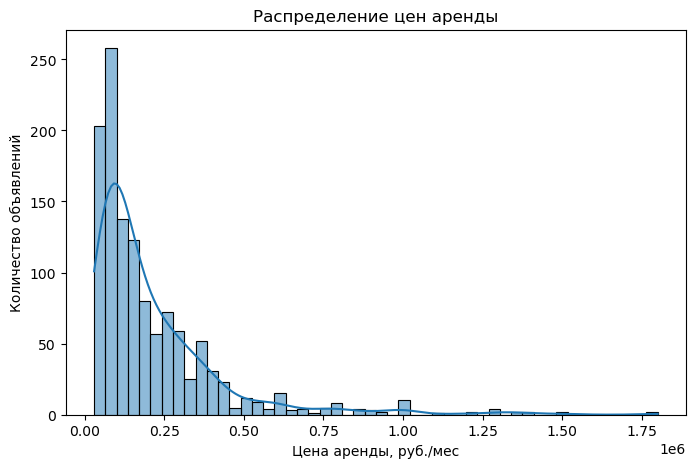

In [356]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['price_monthly'], bins=50, kde=True)
plt.xlabel('Цена аренды, руб./мес')
plt.ylabel('Количество объявлений')
plt.title('Распределение цен аренды')
plt.show()

Распределение цен аренды имеет выраженную правостороннюю асимметрию с длинным правым хвостом. Большинство объявлений сосредоточены в нижнем и среднем ценовых сегментах, при этом небольшая доля дорогих объектов формирует хвост распределения.

Медианная цена аренды составляет около 140 тыс. рублей в месяц. Центральные 50% объявлений находятся в диапазоне от ~80 тыс. до ~265 тыс. рублей, что характеризует основной массовый сегмент рынка. Нижние 10% предложений имеют стоимость до ~58 тыс. рублей и, как правило, соответствуют наиболее доступным объектам. Верхние 10% объявлений превышают 420 тыс. рублей в месяц и формируют выраженный премиальный сегмент.

Наличие длинного правого хвоста и экстремальных значений указывает на выбросы и смещение среднего значения вверх. В таких условиях медиана и квантили лучше описывают типичный уровень цен, чем среднее значение. Для дальнейшего анализа цены целесообразно использовать робастные метрики или рассматривать премиальный сегмент отдельно от массового рынка.

#### 3.4 Анализ влияния площади на цену
Посмотрим, как связаны цена аренды и общая площадь квартиры.

In [359]:
df[['price_monthly', 'total_area']].corr()

,price_monthly,total_area
price_monthly,1.000000,0.738689
total_area,0.738689,1.000000


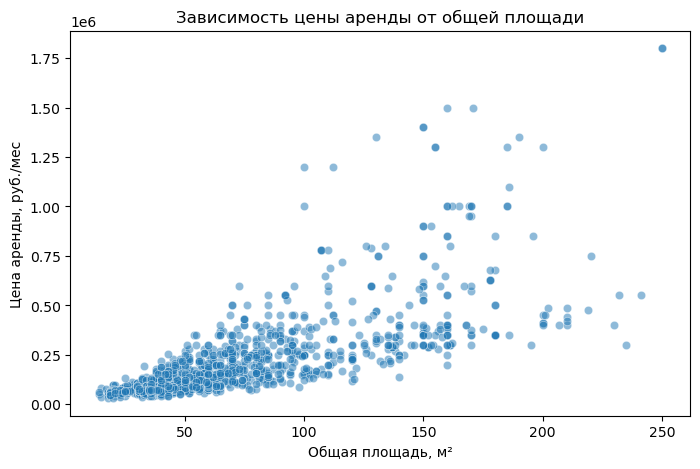

In [360]:
plt.figure(figsize=(8, 5))
sns.scatterplot(
    data=df,
    x='total_area',
    y='price_monthly',
    alpha=0.5
)
plt.xlabel('Общая площадь, м²')
plt.ylabel('Цена аренды, руб./мес')
plt.title('Зависимость цены аренды от общей площади')
plt.show()

Полученное значение корреляции составляет 0.73, что указывает на сильную положительную связь между этими переменными. Это означает, что с увеличением общей площади квартиры, как правило, возрастает и стоимость аренды.

Таким образом, площадь квартиры является одним из ключевых факторов ценообразования на рынке аренды: более просторные квартиры сдаются значительно дороже, чем объекты меньшей площади. При этом высокая корреляция подтверждает, что зависимость носит устойчивый характер, а не является случайной.

#### 3.5 Анализ стоимости аренды за квадратный метр
Рассчитаем стоимость аренды одного квадратного метра и проанализируем её распределение.

In [363]:
df['price_per_m2'] = df['price_monthly'] / df['total_area']

df['price_per_m2'].describe()

count     1221.000000
mean      2802.329073
std       1378.978124
min        877.551020
25%       1875.000000
50%       2465.753425
75%       3333.333333
max      12000.000000
Name: price_per_m2, dtype: float64

Дополнительно рассмотрим районы с самой высокой медианной ценой за квадратный метр.

In [365]:
df.groupby('district')['price_per_m2'].median().sort_values(ascending=False).head(10)

district
Пречистенская наб.              6250.000000
ул. Костикова                   6153.846154
Новоалексеевская ул.            4444.444444
1-й Красногвардейский проезд    4418.604651
пер. 1-й Тружеников             4000.000000
ЦАО                             3333.333333
Нагатинская наб.                3161.290323
Волгоградский просп.            3055.555556
ул. Корнейчука                  2727.272727
Ходынский бул.                  2575.757576
Name: price_per_m2, dtype: float64

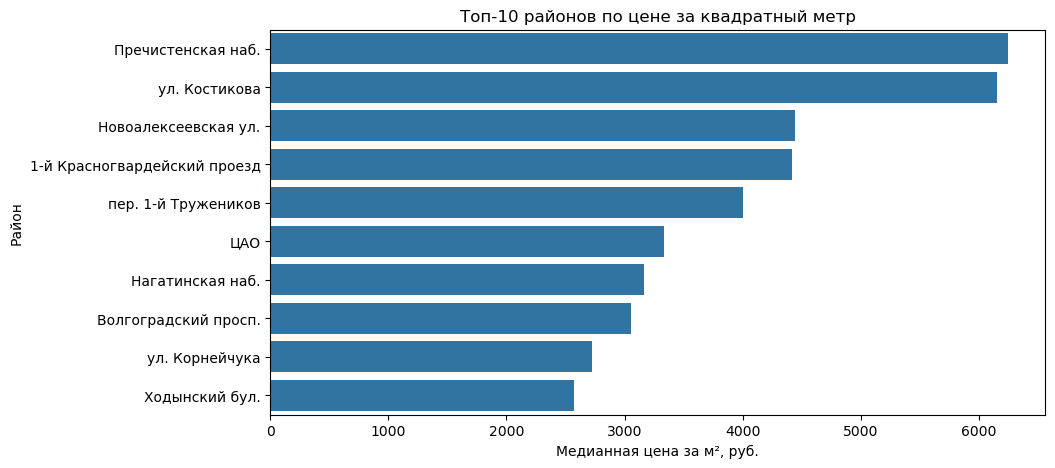

In [366]:
top_price_m2 = (
    df.groupby('district')['price_per_m2']
      .median()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_price_m2.values,
    y=top_price_m2.index
)
plt.xlabel('Медианная цена за м², руб.')
plt.ylabel('Район')
plt.title('Топ-10 районов по цене за квадратный метр')
plt.show()

Медианная стоимость аренды одного квадратного метра составляет около 2 470 руб./м², среднее значение — около 2 800 руб./м². Разница между средним и медианой указывает на асимметричное распределение значений с присутствием дорогих объектов. Диапазон цен за квадратный метр широк: от ~880 руб./м² до 12 000 руб./м², что отражает значительные различия между объектами в выборке.

Сравнение медианных значений по районам показывает, что наибольшая стоимость квадратного метра наблюдается в центральных и престижных локациях, таких как Пречистенская набережная, улица Костикова и Новоалексеевская улица. В этих районах медианная цена за м² существенно превышает общерыночный уровень. В остальных районах из топ-10 значения остаются ниже, но также заметно превосходят медиану по всей выборке.

Полученные результаты указывают на выраженную территориальную дифференциацию цен за квадратный метр. Для более точных выводов о ценовых сегментах рынка требуется дополнительный анализ с учетом размера выборок по районам и других характеристик объектов.

#### 3.6 Анализ зависимости цены на аренду от количества комнат
Проанализируем, как меняется медианная цена аренды в зависимости от количества комнат.

In [369]:
df.groupby('rooms')['price_monthly'].median().sort_index()

rooms
0.0     63500.0
1.0     75000.0
2.0    140000.0
3.0    250000.0
4.0    350000.0
Name: price_monthly, dtype: float64

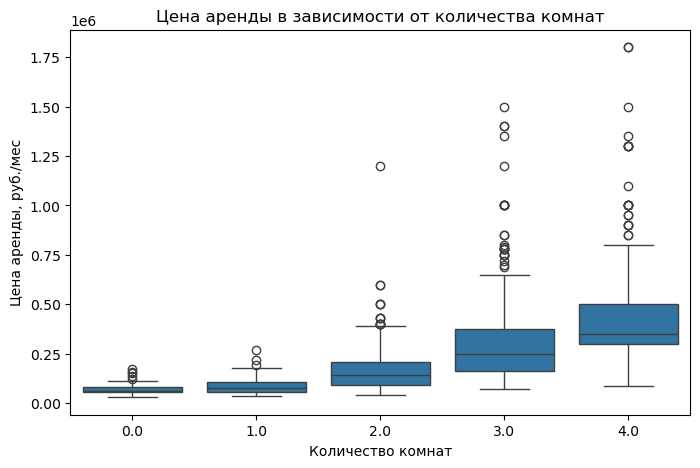

In [370]:
plt.figure(figsize=(8, 5))
sns.boxplot(
    data=df,
    x='rooms',
    y='price_monthly'
)
plt.xlabel('Количество комнат')
plt.ylabel('Цена аренды, руб./мес')
plt.title('Цена аренды в зависимости от количества комнат')
plt.show()

Студии имеют наименьшую медианную стоимость аренды — около 63 тыс. руб. в месяц. Для однокомнатных квартир медианная цена составляет около 75 тыс. руб. При переходе к двухкомнатным квартирам медианная стоимость увеличивается до 140 тыс. руб., что является самым заметным скачком между соседними категориями.

Для трёхкомнатных квартир медианная цена достигает около 250 тыс. руб., для четырёхкомнатных — около 350 тыс. руб. Таким образом, медианная стоимость аренды последовательно растёт с увеличением количества комнат.

График также показывает рост разброса цен для квартир с большим числом комнат, что указывает на более неоднородный уровень предложений в этих категориях. Полученные результаты описывают зависимость цены аренды от количества комнат без учёта площади, локации и других характеристик жилья. Для оценки вклада количества комнат в формирование цены требуется дополнительный анализ с контролем этих факторов.

#### 3.7 Анализ влияния удалённости от метро
Проанализируем, как меняется медианная цена аренды в зависимости от количества комнат.

In [373]:
df[['price_monthly', 'metro_time_minutes']].corr()

,price_monthly,metro_time_minutes
price_monthly,1.000000,-0.114029
metro_time_minutes,-0.114029,1.000000


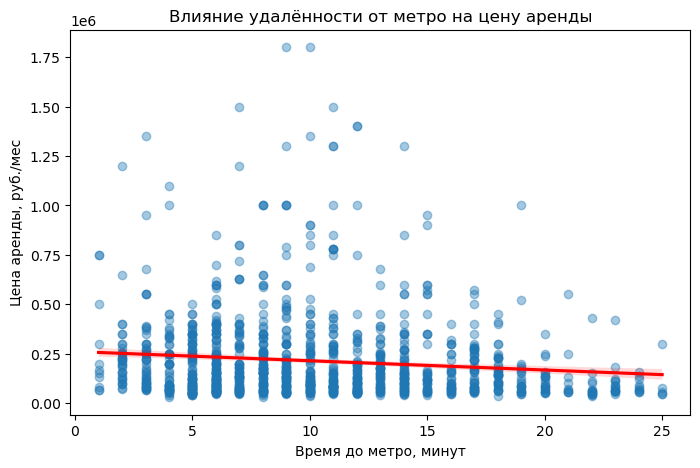

In [374]:
plt.figure(figsize=(8, 5))
sns.regplot(
    data=df,
    x='metro_time_minutes',
    y='price_monthly',
    scatter_kws={'alpha': 0.4},
    line_kws={'color': 'red'}
)
plt.xlabel('Время до метро, минут')
plt.ylabel('Цена аренды, руб./мес')
plt.title('Влияние удалённости от метро на цену аренды')
plt.show()

Коэффициент корреляции между ценой аренды и временем в пути до метро составляет −0.11, что указывает на слабую отрицательную линейную связь между признаками. Это означает, что при увеличении времени в пути до метро цена аренды в среднем имеет тенденцию к снижению, однако эффект выражен слабо.

Диаграмма рассеяния с линией регрессии подтверждает отсутствие выраженной линейной зависимости: при одинаковой удалённости от метро наблюдается широкий разброс цен, включая как бюджетные, так и дорогие предложения.

На основе корреляционного анализа нельзя сделать вывод о значимом влиянии удалённости от метро на стоимость аренды. Для более точной оценки роли данного фактора требуется сравнение цен по интервалам удалённости, а также учёт площади квартиры и района расположения.

#### 3.8 Стоимость аренды в разных районах
Рассмотрим медианные значения цен аренды по районам.

In [377]:
df.groupby('district')['price_monthly'].median().sort_values(ascending=False).head(10)

district
Пречистенская наб.              1000000.0
пер. 1-й Тружеников              600000.0
ул. Костикова                    400000.0
1-й Красногвардейский проезд     380000.0
ЦАО                              300000.0
Русаковская ул.                  300000.0
Проточный пер.                   250000.0
ул. Большие Каменщики            200000.0
Новоалексеевская ул.             200000.0
ЗАО                              165000.0
Name: price_monthly, dtype: float64

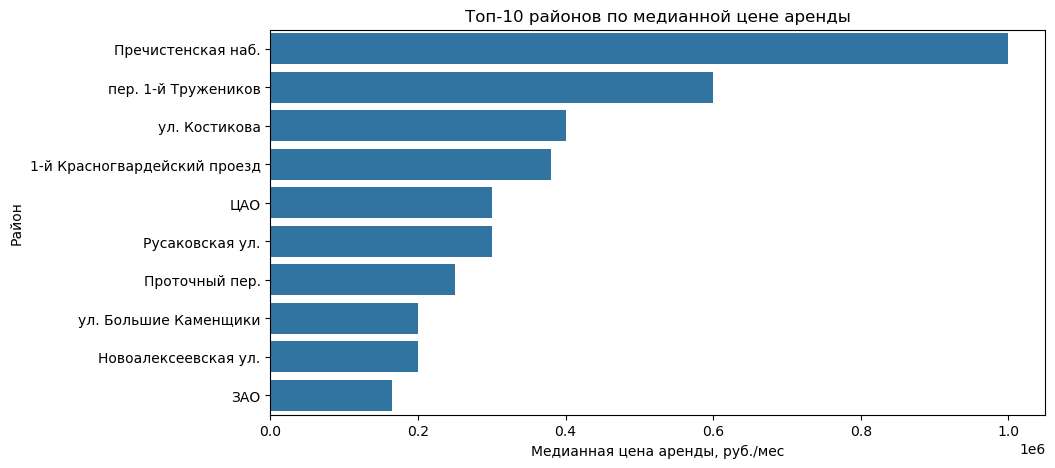

In [378]:
top_districts = (
    df.groupby('district')['price_monthly']
      .median()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(10, 5))
sns.barplot(
    x=top_districts.values,
    y=top_districts.index
)
plt.xlabel('Медианная цена аренды, руб./мес')
plt.ylabel('Район')
plt.title('Топ-10 районов по медианной цене аренды')
plt.show()

Медианные значения цены аренды заметно различаются между районами. В верхней части распределения находятся отдельные улицы и локальные территории, такие как Пречистенская набережная и 1-й Тружеников переулок, где медианная цена существенно превышает медиану по всей выборке.

При этом анализ опирается на агрегирование по полю district, которое содержит как административные районы, так и отдельные улицы. Это означает, что сравниваемые группы могут существенно отличаться по численности и внутренней однородности. В текущем виде результаты отражают различия между локациями, но не позволяют делать обобщённые выводы о районных эффектах без учёта размера групп и качества классификации.

Таким образом, данный анализ фиксирует наличие различий в медианных ценах аренды между локациями, но требует дополнительной проверки устойчивости результатов и более строгого определения территориальных групп для интерпретации влияния района на стоимость аренды.

#### 3.9 Влияние этажа на стоимость аренды
Проверим, отличается ли стоимость аренды для квартир на первом и последнем этажах.

In [381]:
df['is_first_floor'] = df['floor'] == 1
df['is_last_floor'] = df['floor'] == df['total_floors']

df.groupby('is_first_floor')['price_monthly'].median()

is_first_floor
False    140000.0
True      84000.0
Name: price_monthly, dtype: float64

Медианная стоимость аренды для квартир на первом этаже ниже, чем для квартир на остальных этажах. Для первого этажа медиана составляет около 84 тыс. руб. в месяц, для остальных этажей — около 140 тыс. руб. Это указывает на различие уровней цен между двумя группами.

При этом корреляционная матрица показывает почти нулевую линейную связь между этажом и ценой аренды. Это означает, что выявленное различие не носит устойчивого линейного характера и может возникать за счёт структуры выборки или влияния других признаков.

В текущем виде анализ фиксирует ценовое различие между первым и остальными этажами, но не позволяет утверждать наличие самостоятельного эффекта этажа без учёта площади, района и других характеристик квартиры.

#### 3.10 Влияние типа ремонта на стоимость аренды
Проведём анализ медианных цен аренды в зависимости от типа ремонта.

In [384]:
df.groupby('renovation')['price_monthly'].median().sort_values(ascending=False)

renovation
Дизайнерский     180000.0
unknown          150000.0
Евроремонт       100000.0
Косметический     68700.0
Без ремонта       50000.0
Name: price_monthly, dtype: float64

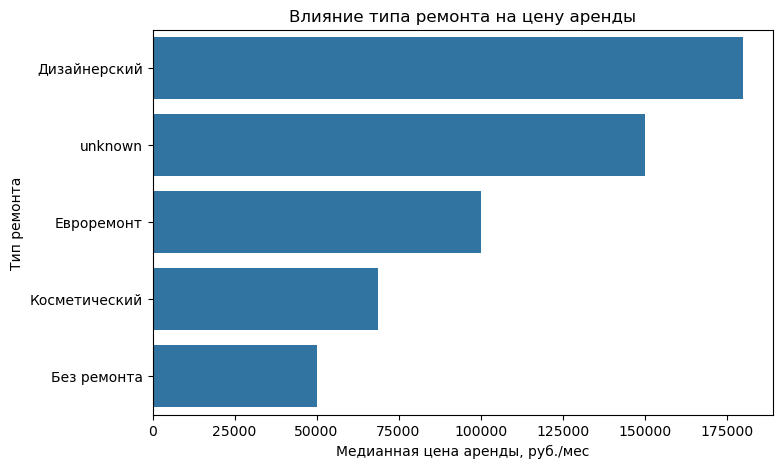

In [385]:
repair_prices = (
    df.groupby('renovation')['price_monthly']
      .median()
      .sort_values(ascending=False)
)

plt.figure(figsize=(8, 5))
sns.barplot(
    x=repair_prices.values,
    y=repair_prices.index
)
plt.xlabel('Медианная цена аренды, руб./мес')
plt.ylabel('Тип ремонта')
plt.title('Влияние типа ремонта на цену аренды')
plt.show()

Медианная стоимость аренды различается в зависимости от указанного типа ремонта. Наибольшая медианная цена наблюдается у квартир с дизайнерским ремонтом (около 180 тыс. руб. в месяц). Ниже располагаются объявления с неуказанным типом ремонта (unknown) — около 150 тыс. руб. Квартиры с евроремонтом имеют медианную цену около 100 тыс. руб., с косметическим ремонтом — около 69 тыс. руб., без ремонта — около 50 тыс. руб.

График показывает устойчивую упорядоченность медианных значений по уровню ремонта: более высокий класс отделки соответствует более высокой цене аренды. При этом данный результат основан на сравнении медиан по группам и не учитывает влияние площади, района и других характеристик жилья. В текущем виде анализ фиксирует различия в уровнях цен между категориями ремонта, но не позволяет делать вывод о причинном влиянии типа ремонта на стоимость аренды.

Категория unknown могла появиться из-за отсутствия информации о ремонте в исходных объявлениях, некорректного заполнения поля арендодателями или ошибок парсинга текста объявлений. Повышенная медианная цена в этой группе может быть связана с тем, что часть арендодателей сознательно не указывает тип ремонта для дорогих объектов, либо с неоднородным составом группы.

Для подтверждения влияния типа ремонта требуется дополнительный анализ с контролем площади и локации, а также проверка устойчивости результатов по размерам групп.

#### 3.11 Влияние мебели и техники на стоимость аренды
Проведем анализ зависимости наличия бытовой техники и дополнительных удобств на стоимость аренды.

In [388]:
amenities = [
    'has_fridge', 'has_dishwasher', 'has_washing_machine',
    'has_conditioner', 'has_tv', 'has_internet'
]

df.groupby(amenities)['price_monthly'].median().sort_values(ascending=False).head(10)

has_fridge  has_dishwasher  has_washing_machine  has_conditioner  has_tv  has_internet
0           1               0                    1                1       0               750000.0
1           0               0                    1                1       0               525000.0
                                                 0                0       1               350000.0
0           0               0                    0                1       0               305000.0
1           1               0                    0                1       1               300000.0
0           0               0                    0                0       1               280000.0
                                                 1                0       0               275000.0
1           1               1                    1                1       0               250000.0
0           1               1                    0                0       1               247500.0
            0         

Результаты показывают, что наличие мебели и бытовой техники в целом связано с более высокой стоимостью аренды, однако влияние отдельных удобств неоднородно. Наибольшие медианные цены наблюдаются у квартир с расширенным набором удобств (например, наличие кондиционера, телевизора и посудомоечной машины одновременно), что, вероятно, отражает более высокий класс жилья. При этом встречаются дорогие варианты и с неполным набором техники, что указывает на влияние других факторов — таких как площадь, локация и уровень ремонта. В целом, наличие техники и мебели повышает привлекательность объекта и может способствовать росту арендной ставки, но само по себе не является единственным определяющим фактором цены.

#### 3.12 Влияние типа владельца объявления на стоимость аренды
Изучим зависимости медианных цен аренды от типа владельца объявления.

In [391]:
df.groupby('agent_type')['price_monthly'].median()

agent_type
agency     220000.0
other      260000.0
unknown    110000.0
Name: price_monthly, dtype: float64

Медианная стоимость аренды различается в зависимости от типа владельца объявления. Наибольшая медианная цена наблюдается в категории other — около 260 тыс. руб. в месяц. Объявления от агентств имеют более низкую медианную цену — около 220 тыс. руб. Минимальные значения характерны для категории unknown — около 110 тыс. руб.

В рамках данного анализа сравниваются медианные цены между группами объявлений, размещённых агентствами и не агентствами. Полученные различия отражают особенности состава групп, а не причинное влияние типа владельца объявления на цену аренды. Возможен эффект селекции: агенты и частные лица могут публиковать объекты разных ценовых сегментов, а категория other может включать как собственников, так и дорогие объекты с нестандартным типом размещения.

Категория unknown могла возникнуть из-за отсутствия информации о типе владельца в исходных данных или ошибок при парсинге объявлений. Низкая медианная цена в этой группе указывает на её неоднородность и ограниченную интерпретируемость.

В текущем виде анализ фиксирует различия медианных цен между типами владельцев объявлений, но не позволяет делать вывод о влиянии типа владельца на стоимость аренды без учёта размеров групп, района и характеристик жилья.

#### 3.13 Корреляционная матрица числовых признаков
Проведем более детальный анализ взаимосвязей между числовыми признаками и рассчитаем корреляционную матрицу.

In [394]:
numeric_cols = [
    'price_monthly', 'total_area', 'living_area', 'kitchen_area',
    'rooms', 'floor', 'total_floors', 'metro_time_minutes', 'build_year'
]

df[numeric_cols].corr()

,price_monthly,total_area,living_area,kitchen_area,rooms,floor,total_floors,metro_time_minutes,build_year
price_monthly,1.000000,0.738689,0.518281,0.323242,0.562938,0.005373,-0.036823,-0.114029,-0.052074
total_area,0.738689,1.000000,0.717155,0.422069,0.828411,-0.070441,-0.091676,-0.119714,-0.222105
living_area,0.518281,0.717155,1.000000,0.316186,0.637701,-0.065421,-0.079360,-0.138698,-0.194090
kitchen_area,0.323242,0.422069,0.316186,1.000000,0.404161,0.007391,0.071016,-0.017893,0.013007
rooms,0.562938,0.828411,0.637701,0.404161,1.000000,-0.069013,-0.078783,-0.087691,-0.259171
floor,0.005373,-0.070441,-0.065421,0.007391,-0.069013,1.000000,0.781790,-0.030128,0.291182
total_floors,-0.036823,-0.091676,-0.079360,0.071016,-0.078783,0.781790,1.000000,0.010814,0.407071
metro_time_minutes,-0.114029,-0.119714,-0.138698,-0.017893,-0.087691,-0.030128,0.010814,1.000000,0.185204
build_year,-0.052074,-0.222105,-0.194090,0.013007,-0.259171,0.291182,0.407071,0.185204,1.000000


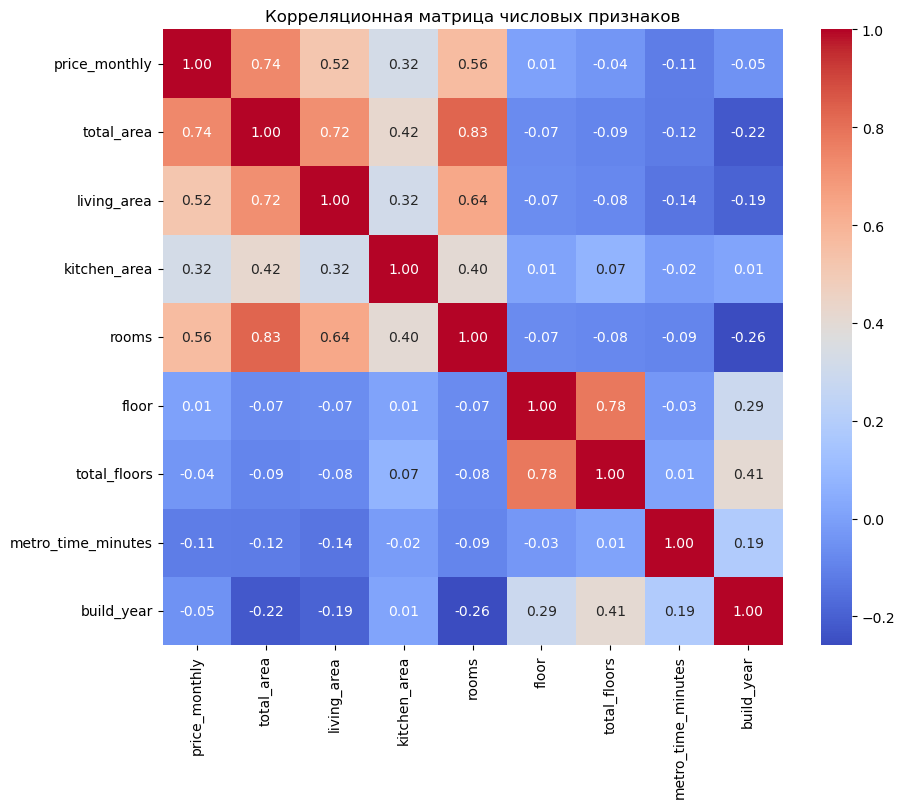

In [395]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df[numeric_cols].corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm'
)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

Наиболее сильная положительная корреляция наблюдается между ценой аренды и общей площадью квартиры (0.74), а также жилой площадью (0.74). Это ожидаемый результат, так как более просторные квартиры, как правило, сдаются дороже.

Также заметна умеренная положительная связь между ценой аренды и количеством комнат (0.56), что подтверждает влияние планировки и размера жилья на стоимость.

Отрицательная корреляция между ценой аренды и временем в пути до метро (-0.11) указывает на то, что удалённость от метро оказывает умеренное, но заметное влияние на снижение арендной ставки.

Связь стоимости аренды с этажом и общим количеством этажей в доме выражена слабо, что говорит о второстепенной роли этих факторов по сравнению с площадью и локацией.

Интересно отметить отрицательную корреляцию между годом постройки и площадью квартиры, что может быть связано с тем, что в более новых домах чаще встречаются квартиры меньшей площади. В целом, ключевыми факторами, влияющими на цену аренды, остаются площадь квартиры, количество комнат и транспортная доступность.